In [173]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [174]:
model_id = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.001'
input_dir ='/mnt/home/dheurtel/ceph/04_inference/sbc/'+model_id

In [175]:
sbc_files = [f for f in os.listdir(input_dir)]
sbc_files.sort()
print(sbc_files)

noise_levels = np.unique(np.array([float(f.split("_")[2]) for f in sbc_files]))
print("Noise levels:", noise_levels)

['sbc_sims_0.1_0.pt', 'sbc_sims_0.1_1.pt', 'sbc_sims_0.1_2.pt', 'sbc_sims_0.1_3.pt', 'sbc_sims_0.1_4.pt', 'sbc_sims_0.2_0.pt', 'sbc_sims_0.2_1.pt', 'sbc_sims_0.2_2.pt', 'sbc_sims_0.2_3.pt', 'sbc_sims_0.2_4.pt', 'sbc_sims_0.3_0.pt', 'sbc_sims_0.3_1.pt', 'sbc_sims_0.3_2.pt', 'sbc_sims_0.3_3.pt', 'sbc_sims_0.3_4.pt']
Noise levels: [0.1 0.2 0.3]


In [176]:
# Load files
phi_truth_all = {}
phi_samples_all = {}
max_num_samples = 400
for noise_level in noise_levels:
    print("Noise level:", noise_level)
    phi_truth_all[noise_level] = None
    phi_samples_all[noise_level] = None
    for sbc_file in [f for f in sbc_files if f.find(str(noise_level)) != -1]:
        print(sbc_file)
        sbc_file = os.path.join(input_dir, sbc_file)
        sbc_data = torch.load(sbc_file)
        phi_truth = sbc_data["rphi_true"].detach().cpu()
        phi_samples = sbc_data["tensor_rphi_list"].detach().cpu()
        if phi_truth_all[noise_level] is None:
            if phi_samples.shape[0] < max_num_samples:
                continue
            phi_truth_all[noise_level] = phi_truth
            phi_samples_all[noise_level] = phi_samples[:max_num_samples, :, :]
        else:
            if phi_samples.shape[0] < max_num_samples:
                continue
            phi_truth_all[noise_level] = torch.cat((phi_truth_all[noise_level], phi_truth), dim=0)
            phi_samples_all[noise_level] = torch.cat((phi_samples_all[noise_level], phi_samples[:max_num_samples, :, :]), dim=1)
    try:
        print(phi_truth_all[noise_level].shape, phi_samples_all[noise_level][:max_num_samples, :, :].shape)
    except:
        print("No samples for noise level", noise_level)

Noise level: 0.1
sbc_sims_0.1_0.pt
sbc_sims_0.1_1.pt
sbc_sims_0.1_2.pt
sbc_sims_0.1_3.pt
sbc_sims_0.1_4.pt
torch.Size([1024, 2]) torch.Size([400, 1024, 2])
Noise level: 0.2
sbc_sims_0.2_0.pt
sbc_sims_0.2_1.pt
sbc_sims_0.2_2.pt
sbc_sims_0.2_3.pt
sbc_sims_0.2_4.pt
torch.Size([256, 2]) torch.Size([400, 256, 2])
Noise level: 0.3
sbc_sims_0.3_0.pt
sbc_sims_0.3_1.pt
sbc_sims_0.3_2.pt
sbc_sims_0.3_3.pt
sbc_sims_0.3_4.pt
torch.Size([512, 2]) torch.Size([400, 512, 2])


In [177]:
nb_burning_samples = 61

noise_levels = [0.1, 0.2]

# Get rid of the burnin samples
for noise_level in noise_levels:
    phi_samples_all[noise_level] = phi_samples_all[noise_level][nb_burning_samples:, :, :]

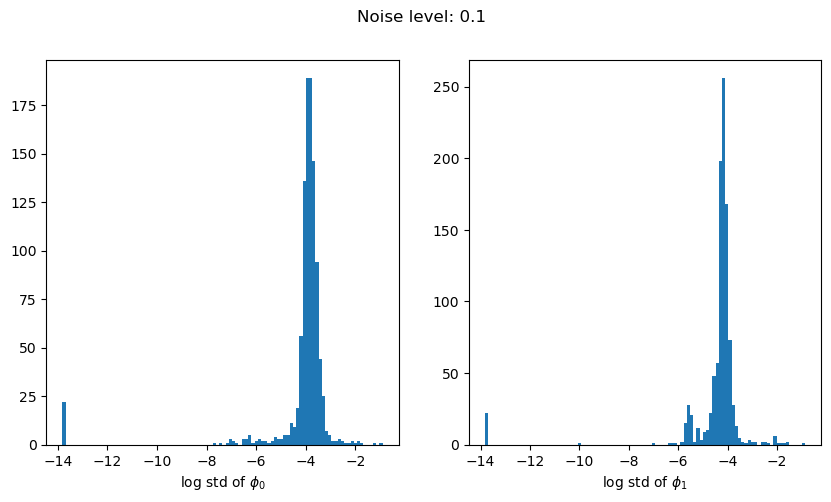

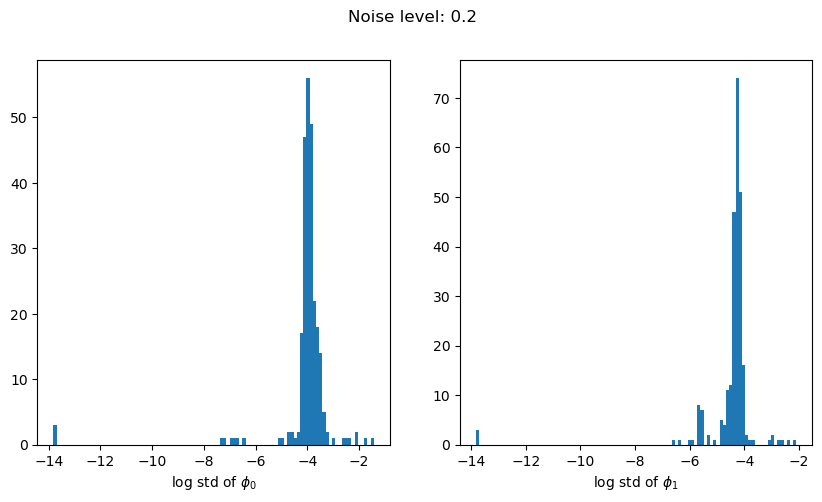

In [178]:
# Show histogram of stds
eps = 1e-6
for noise_level in noise_levels:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps), bins=100)
    axs[0].set_xlabel("log std of $\phi_0$")
    axs[1].hist(torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps), bins=100)
    axs[1].set_xlabel("log std of $\phi_1$")
    plt.suptitle("Noise level: " + str(noise_level))
    plt.show()

In [179]:
# Remove chains that have not converged
# Add a condition about distance to the true value (if mean dist larger than 0.5, then remove)

threshold = -6
converged_indices = {}
not_converged_indices = {}
for noise_level in noise_levels:
    print("Noise level:", noise_level)
    converged_indices[noise_level] = torch.where(torch.logical_and(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps) >= threshold,torch.logical_and(
                                                    torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps) >= threshold, 
                                                    torch.norm(phi_samples_all[noise_level].mean(dim=0) - phi_truth_all[noise_level], dim=1) <=0.5,)))[0]
    not_converged_indices[noise_level] = torch.where(torch.logical_or(torch.logical_or(torch.log(phi_samples_all[noise_level][..., 0].std(dim=0) + eps) < threshold,
                                                        torch.log(phi_samples_all[noise_level][..., 1].std(dim=0) + eps) < threshold), 
                                                        torch.norm(phi_samples_all[noise_level].mean(dim=0) - phi_truth_all[noise_level], dim=1) > 0.5))[0]
    print("Number of chains that have not converged:", not_converged_indices[noise_level].shape[0])

Noise level: 0.1
Number of chains that have not converged: 83
Noise level: 0.2
Number of chains that have not converged: 13


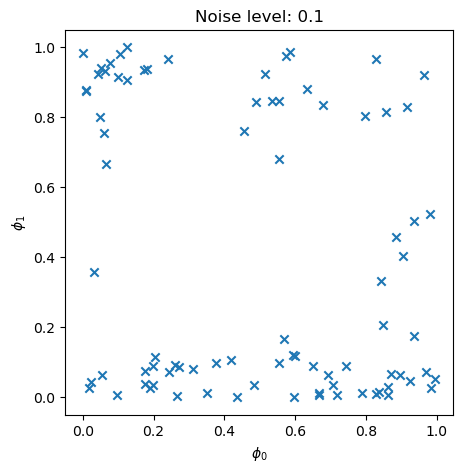

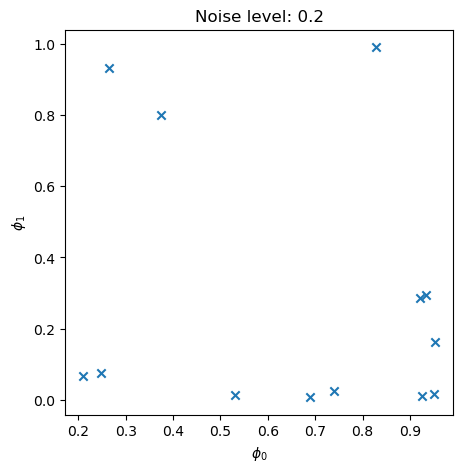

In [180]:
# Plot parameters for the chains that have not converged
for noise_level in noise_levels:
    plt.figure(figsize=(5, 5))
    plt.scatter(phi_truth_all[noise_level][not_converged_indices[noise_level], 0],
                phi_truth_all[noise_level][not_converged_indices[noise_level], 1],
                marker='x')
    plt.xlabel("$\phi_0$")
    plt.ylabel("$\phi_1$")
    plt.title("Noise level: " + str(noise_level))
    plt.show()

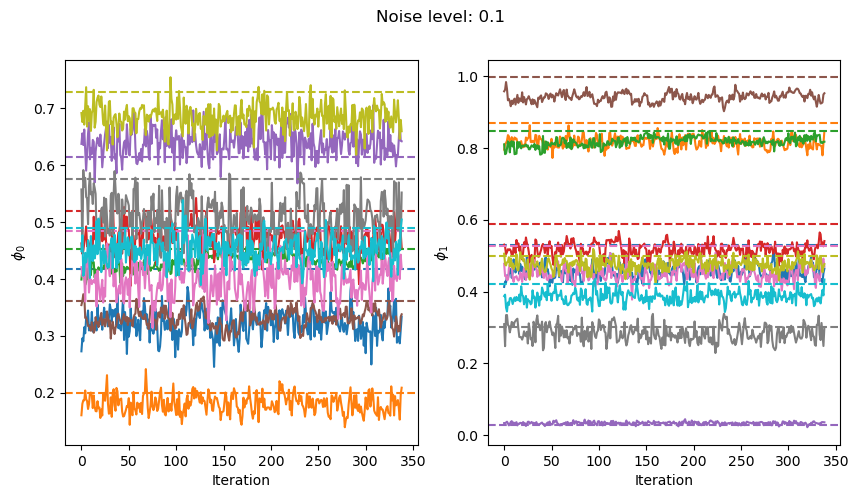

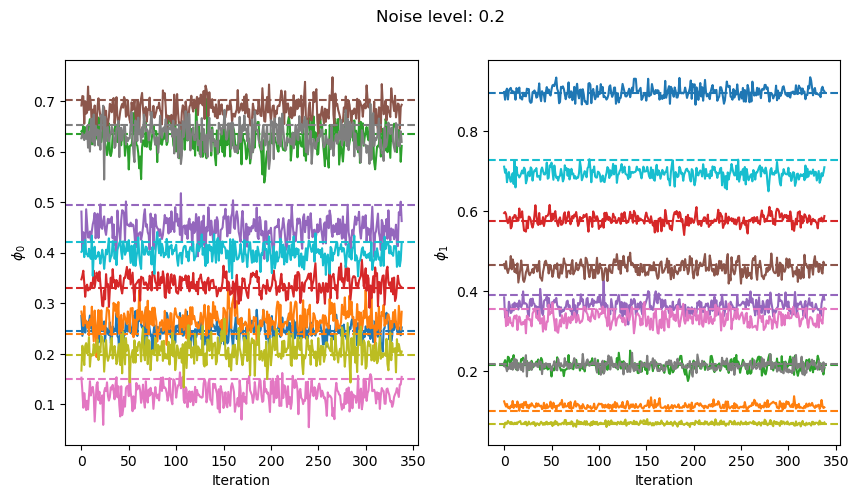

In [181]:
# Plot randomly selected chains
nb_plot_chains = 10

for noise_level in noise_levels:

    plot_indices = torch.randperm(phi_samples_all[noise_level][:,converged_indices[noise_level]].shape[1])[:nb_plot_chains]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(nb_plot_chains):
        axs[0].plot(phi_samples_all[noise_level][:,converged_indices[noise_level]][:, plot_indices[i], 0], color=f'C{i}')
        axs[0].axhline(phi_truth_all[noise_level][converged_indices[noise_level]][plot_indices[i], 0], color=f'C{i}', linestyle='--')
        axs[1].plot(phi_samples_all[noise_level][:,converged_indices[noise_level]][:, plot_indices[i], 1], color=f'C{i}')
        axs[1].axhline(phi_truth_all[noise_level][converged_indices[noise_level]][plot_indices[i], 1], color=f'C{i}', linestyle='--')
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("$\phi_0$")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("$\phi_1$")
    plt.suptitle("Noise level: " + str(noise_level))
    plt.show()

In [182]:
# Compute rank statistics
ranks = {}
for noise_level in noise_levels:
    phi_truth_all_converged = phi_truth_all[noise_level][converged_indices[noise_level], :]
    phi_samples_all_converged = phi_samples_all[noise_level][:, converged_indices[noise_level], :]
    ranks[noise_level] = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
    autocorrelation_length = torch.zeros(phi_truth_all_converged.shape[0], phi_truth_all_converged.shape[1])
    for i in range(phi_truth_all_converged.shape[0]):
        az_infdata = az.convert_to_inference_data(phi_samples_all_converged[:, i][None, :].numpy())
        for j in range(phi_truth_all_converged.shape[1]):
            autocorrelation_length[i, j] = len(phi_samples_all_converged[:, i, j]) / az.ess(az_infdata)['x'].values[j]
            ranks[noise_level][i, j] = torch.mean((phi_samples_all_converged[::max(int(autocorrelation_length[i, j]), 1), i, j] < phi_truth_all_converged[i, j]).float())

In [183]:
from scipy.stats import binom

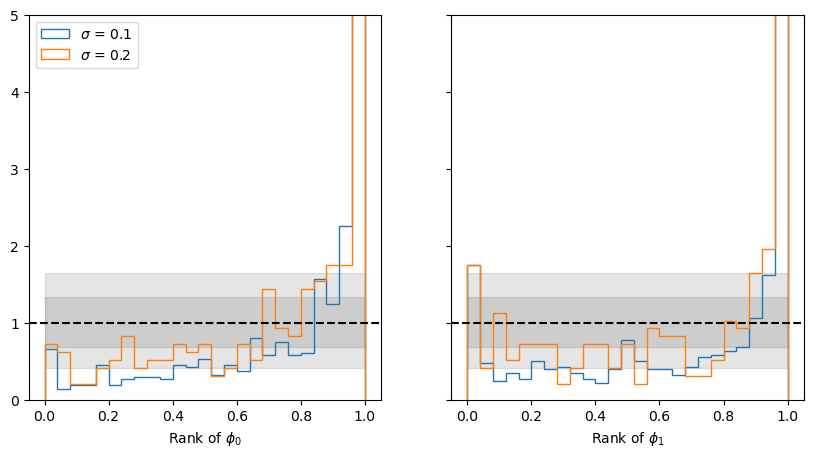

In [184]:
# Plot ranks statistics
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for noise_level in noise_levels:
    axs[0].hist(ranks[noise_level][:, 0], bins=25, density=True, histtype='step', label=f"$\sigma$ = {noise_level}")
    axs[1].hist(ranks[noise_level][:, 1], bins=25, density=True, histtype='step')
    nbins = 25
    N = ranks[noise_level].shape[0]
    q0 = binom.ppf(0.025, N, 1.0/nbins) * nbins/N
    q1 = binom.ppf(0.975, N, 1.0/nbins) * nbins/N
    axs[0].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
    axs[1].fill_between([0, 1], q0, q1, color='black', alpha=0.1) # 95% confidence interval (following Talts et al. 2018)
axs[0].axhline(1.0, color='black', linestyle='--')
axs[0].set_xlabel("Rank of $\phi_0$")
axs[1].axhline(1.0, color='black', linestyle='--')
axs[1].set_xlabel("Rank of $\phi_1$")
axs[0].legend()
axs[0].set_ylim([0, 5])
plt.show()